<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw22/hw2_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pickle
from torch.utils.data import DataLoader
import torchvision
from matplotlib import pyplot as plt

In [2]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [3]:
with open('hw2_q2.pkl', 'rb') as f:
    DATA = pickle.load(f)
print(DATA.keys())
DATA['train'] = torch.FloatTensor(DATA['train']).permute(0, 3, 1, 2)
DATA['test'] = torch.FloatTensor(DATA['test']).permute(0, 3, 1, 2)
print(DATA['train'].shape)
print(DATA['test'].shape)

dict_keys(['train', 'test'])
torch.Size([20000, 3, 32, 32])
torch.Size([6838, 3, 32, 32])


In [0]:
def show(images):
    images = images.permute(0, 2, 3, 1)
    fig=plt.figure(figsize=(8, 8))
    columns = images.shape[0]
    rows = 1
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img / 3)

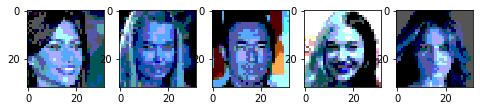

In [5]:
show(DATA['train'][:5])

In [0]:
class ResNetBlock(nn.Module):
    def __init__(self, ch_in, n_filters=256, n_blocks=8):
        super(ResNetBlock,self).__init__()
        ch_out = ch_in * 2
        self.n_blocks = n_blocks
        self.conv1 = nn.Conv2d(ch_in, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=2)
        self.batch_norm1 = nn.BatchNorm2d(n_filters)
        get_ht_model = lambda: nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel_size=(1, 1), stride=(1, 1), padding=0),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(n_filters)
        )
        get_h_model = lambda: nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size=(1,1), stride=(1, 1), padding=0),
            nn.BatchNorm2d(n_filters)
        )
        self._h_model = torch.nn.ModuleList([get_ht_model() for _ in range(n_blocks)])
        self.h_model = torch.nn.ModuleList([get_h_model() for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_filters, ch_out, kernel_size=(3, 3), stride=(1, 1))
        self.batch_norm2 = nn.BatchNorm2d(ch_out)
    
    def forward(self, x):
        h = self.conv1(x)
        h = self.batch_norm1(h)
        for i in range(self.n_blocks):
            _h = self._h_model[i](h)
            h = self.h_model[i](_h)
            h = (h + _h)
        h = F.relu(h)
        x = self.conv2(h)
        x = self.batch_norm2(x)
        return x

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, ch_in):
        super(AffineCoupling, self).__init__()
        self.resnet = ResNetBlock(ch_in)
    
    def forward(self, x, masks):
        (x1, x2) = x
        y1 = x1
        log_s, t = torch.chunk(self.resnet(x1), 2, dim=1)
        y2 = torch.exp(log_s) * (x2 + t * masks[1])
        log_det = log_s.view(x1.shape[0], -1).sum(dim=1)
        return ((y1, y2), log_det)

    def reverse(self, y, mask):
        (y1, y2) = y
        x1 = y1
        log_s, t = torch.chunk(self.resnet(x1), 2, dim=1)
        x2 = y2 * torch.exp(-log_s) - t * (1 - mask[1])
        return (x1, x2)

In [0]:
class CelebA(nn.Module):
  def __init__(self, ch_in):
      super(CelebA, self).__init__()
      self.prior = Normal(torch.tensor(0.).to(DEVICE), torch.tensor(1.).to(DEVICE))
      self.couplings1 = torch.nn.ModuleList([AffineCoupling(ch_in) for i in range(4)])
      self.couplings2 = torch.nn.ModuleList([AffineCoupling(ch_in * 4) for i in range(3)])
      self.couplings3 = torch.nn.ModuleList([AffineCoupling(ch_in * 4) for i in range(3)])
      self.couplings4 = torch.nn.ModuleList([AffineCoupling(ch_in * 16) for i in range(3)])
      self.couplings5 = torch.nn.ModuleList([AffineCoupling(ch_in * 16) for i in range(3)])

  def build_mask(self, size, config=1.):
      mask = np.arange(size).reshape(-1, 1) + np.arange(size)
      mask = np.mod(config + mask, 2)
      mask = mask.reshape(-1, 1, size, size)
      return torch.tensor(mask.astype('float32'))

  def flip_tuple(self, x, masks):
      (x1, x2) = x
      (mask1, mask2) = masks
      return (x2, x1), (mask2, mask1)

  def checkerboard_split(self, x):
      mask = self.build_mask(x.shape[2], config=1.).to(DEVICE)
      return (x * mask, x * (1 - mask)), (mask, 1 - mask)

  def squeeze(self, x):
      x = x.reshape(-1, 4 * x.shape[1], x.shape[2] // 2, x.shape[3] // 2)
      return x
  
  def unsqueeze(self, x):
      x = x.reshape(-1, x.shape[1] // 4, x.shape[2] * 2, x.shape[3] * 2)
      return x

  def channel_split(self, x):
      mask = torch.zeros((1, x.shape[1], x.shape[2], x.shape[3])).to(DEVICE)
      mask[:, :mask.shape[1] // 2, :, :] = 1
      return (x * mask, x * (1 - mask)), (mask, 1 - mask)

  def forward(self, x):
      log_det = 0

      x, masks = self.checkerboard_split(x) 
      for i in range(4):
          x, log_det_temp = self.couplings1[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = x[0] + x[1]
      
      x = self.squeeze(x)
      
      x, masks = self.channel_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings2[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = x[0] + x[1]

      x, masks = self.checkerboard_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings3[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = x[0] + x[1]
      
      x = self.squeeze(x)
      
      x, masks = self.channel_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings4[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = x[0] + x[1]

      x, masks = self.checkerboard_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings5[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = x[0] + x[1]

      return x, log_det
    
  def log_prob(self, x):
      z, log_det_J = self.forward(x)
      return torch.sum(self.prior.log_prob(z), dim=(1, 2, 3)) + log_det_J

In [0]:
def plot_losses(losses, val_losses):
    plt.plot(losses, label = "train_loss")
    plt.plot(val_losses, label = "val_loss")
    plt.legend()
    plt.show()

In [0]:
dim_factor = torch.FloatTensor([3 * 32 * 32]).to(DEVICE)
log_factor = torch.log(torch.Tensor([2])).to(DEVICE)

In [0]:
def loss_func(log_prob):
    return -torch.mean(log_prob) / (dim_factor * log_factor)

In [0]:
epochs_cnt = 1
model = CelebA(3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=0.0001)

In [0]:
train_data=DATA['train'][:160]
test_data=DATA['test'][:32]

In [0]:
def train():
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    val_iter = DataLoader(test_data, batch_size=16, shuffle=False)
    
    loss_train, loss_val = [], []
    for epoch in range(epochs_cnt):
        losses = []
        
        model.train()
        for batch in train_loader:
            batch = batch.to(DEVICE)
            loss = loss_func(model.log_prob(batch))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.data.cpu().numpy())
        loss_train.append(np.mean(losses))
        
        model.eval()
        with torch.no_grad():
            losses = []
            for item in val_iter:
                batch = batch.to(DEVICE)
                val_loss = loss_func(model.log_prob(batch))
                losses.append(val_loss.data.cpu().numpy())
            loss_val.append(np.mean(losses))

        print("It: " + str(epoch) + " Train loss: " + str(loss_train[-1]) + " Val loss: " + str(loss_val[-1]))
    return loss_train, loss_val

It: 0 Train loss: nan Val loss: nan


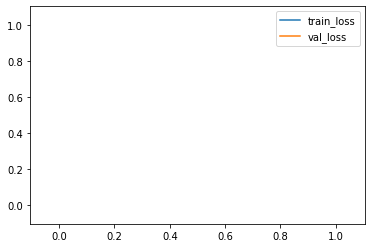

In [15]:
loss_train, loss_val = train()
plot_losses(loss_train, loss_val)